# AirBnB Customer Segmentation

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import os

In [7]:
path = '/Users/admin/Documents/BC#2/Labs/Week08/AirBnB-customer-segmentation/'

In [8]:
df = pd.read_csv(path+"AB_NYC_2019.csv")

In [9]:
df.head(15)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
6,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,2017-10-05,0.40,1,0
7,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220
8,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,2017-07-21,0.99,1,0
9,5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,2019-06-09,1.33,4,188


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

The columns `last_review` and `reviews_per_month` are the ones presenting the highest number of missing values, therefore the NaN are removed. 
Secondly, `host_name` and `name` present a few missing values and also those are removed. 

In [11]:
# Drop NAs
df.dropna(inplace = True)
df.reset_index(inplace = True, drop = True)

In [12]:
# Convert revelant categorical columns into integers
df['neighbourhood_group'] = df['neighbourhood_group'].map({'Brooklyn':1, 'Manhattan':2, 'Queens':3, 'Staten Island':4, 'Bronx':5})
df['room_type'] = df['room_type'].map({'Private room':1, 'Entire home/apt':2, 'Shared room':3})

array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

In [19]:
# Select columns with numerical values
df_num = df.select_dtypes("number").copy()

In [21]:
# drop unnecessary columns
df_num.drop(columns=['host_id', 'id', 'latitude', 'longitude'], inplace = True)

### Selecting number of clusters for k-means classification

#### The elbow method

In [29]:
# first we have to get the inertia values for a variety of different cluster numbers
inertia_dict = {
    'clusters': [],
    'inertia': []
}

for i in range(2,11): # we choose 2 as the minimum number of clusters. It doesnt really make sense to have 1 cluster
    scaler = StandardScaler()
    cluster = KMeans(n_clusters=i) # here we set the number of clusters for every iteration
    pipe = make_pipeline(scaler, cluster)
    pipe.fit(df_num)
    inertia_dict['clusters'].append(i)
    inertia_dict['inertia'].append(pipe['kmeans'].inertia_)

inertia_df = pd.DataFrame(inertia_dict)

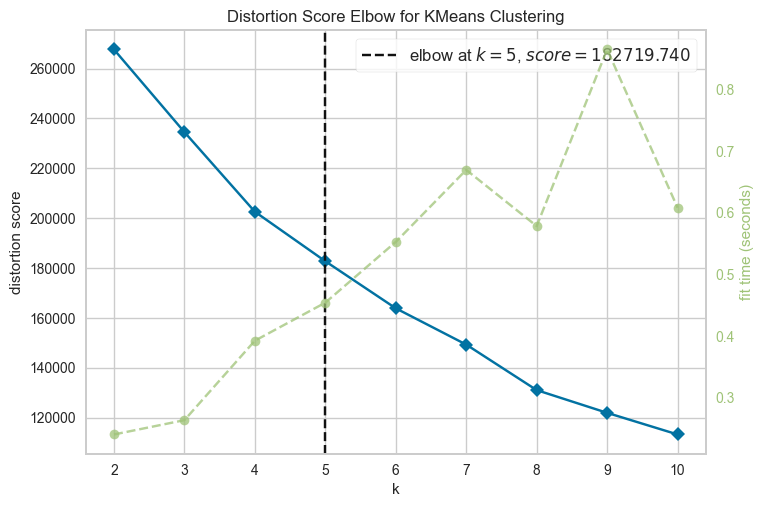

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [30]:
scaler = StandardScaler()
cluster = KElbowVisualizer(KMeans(n_init=10))
pipe = make_pipeline(scaler, cluster)

pipe.fit(df_num)
pipe[1].show()

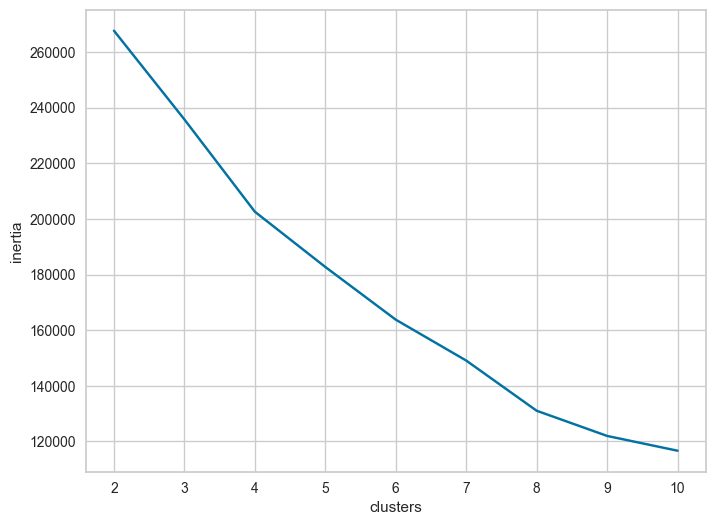

In [32]:
plt.figure(figsize=(8, 6))
g = sns.lineplot(data=inertia_df, x='clusters', y='inertia')
plt.show()

The elbow method suggests 5 clusters.

#### Clustering the data

In [33]:
scaler = StandardScaler()
cluster = KMeans(n_clusters=5)
pipe = make_pipeline(scaler, cluster)
pipe.fit(df_num)

values = pipe[:1].transform(df_num)

df["clusters"] = pipe["kmeans"].labels_

df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,clusters
0,2539,Clean & quiet apt home by the park,2787,John,1,Kensington,40.64749,-73.97237,1,149,1,9,2018-10-19,0.21,6,365,0
1,2595,Skylit Midtown Castle,2845,Jennifer,2,Midtown,40.75362,-73.98377,2,225,1,45,2019-05-21,0.38,2,355,0
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,1,Clinton Hill,40.68514,-73.95976,2,89,1,270,2019-07-05,4.64,1,194,1
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,2,East Harlem,40.79851,-73.94399,2,80,10,9,2018-11-19,0.10,1,0,4
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,2,Murray Hill,40.74767,-73.97500,2,200,3,74,2019-06-22,0.59,1,129,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38816,36425863,Lovely Privet Bedroom with Privet Restroom,83554966,Rusaa,2,Upper East Side,40.78099,-73.95366,1,129,1,1,2019-07-07,1.00,1,147,3
38817,36427429,No.2 with queen size bed,257683179,H Ai,3,Flushing,40.75104,-73.81459,1,45,1,1,2019-07-07,1.00,6,339,0
38818,36438336,Seas The Moment,211644523,Ben,4,Great Kills,40.54179,-74.14275,1,235,1,1,2019-07-07,1.00,1,87,3
38819,36442252,1B-1B apartment near by Metro,273841667,Blaine,5,Mott Haven,40.80787,-73.92400,2,100,1,2,2019-07-07,2.00,1,40,4


In [34]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'clusters'],
      dtype='object')

In [38]:
cluster_sizes = df.groupby('clusters').size().to_frame()
cluster_sizes.columns = ["size"]
cluster_sizes

,size
clusters,
0,8653
1,5351
2,235
3,11341
4,13241


#### Plotting column by cluster 

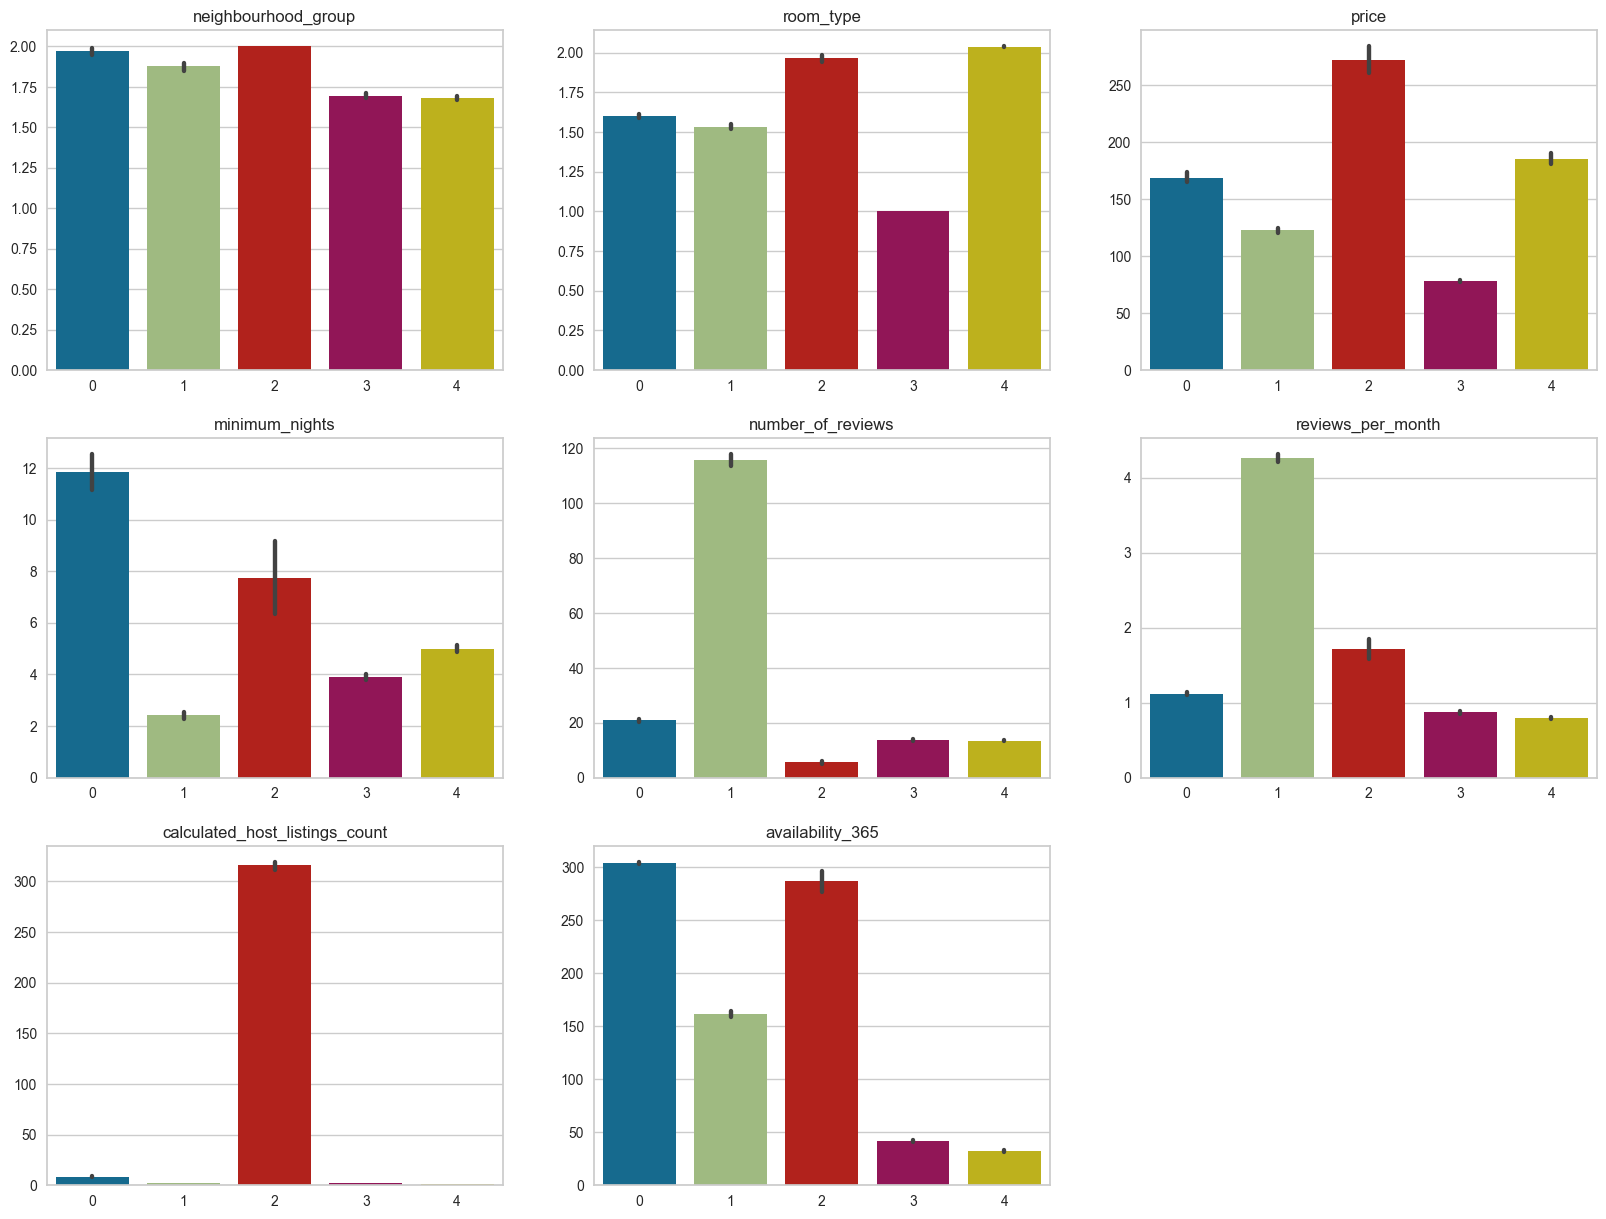

In [36]:
import math

var_list = ['neighbourhood_group','room_type', 'price',
       'minimum_nights', 'number_of_reviews','reviews_per_month', 'calculated_host_listings_count',
       'availability_365' ]

cols=3

rows = math.ceil(len(var_list)/cols)

fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize = (20, 5*rows))

for i, ax in zip(var_list, axs.flat):
    g = sns.barplot(data = df, x="clusters", y=i, ax = ax)
    ax.set(xlabel="", ylabel ="", title=i)
    
    
# Flat the plot: go backwards and drop the "ax" that is not plotting anything
for i in axs.flat[::-1][:rows*cols-len(var_list)]:
    i.set_axis_off()
    
plt.show()